# Installs and Download Demo data

**IMPORTANT** 
Restart the kernel after first installation to avoid this error:

`ImportError: cannot import name '_png' from 'matplotlib'`

In [1]:
!pip install -q gdown nannyml

## Download Data Drift Module and Demo Data

In [2]:
import gdown

# Data Drift Module FROZEN version 28/12/2022 - can also be taken from:
# !git clone https://github.com/mryanivtal/mlops.git
!gdown 1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
!unzip -n mlops-main.zip
# !cp -n /content/drive/MyDrive/2023/S1/3690_MLOPs/mlops_project/POCs/mlops-main.zip . && 

# Sample dataset CSV file for the Demo
!gdown 1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
!gdown 1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
!gdown 1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P


Downloading...
From: https://drive.google.com/uc?id=1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
To: /content/mlops-main.zip
100% 457k/457k [00:00<00:00, 110MB/s]
Archive:  mlops-main.zip
8088abac49dac64a684b618b874b0c78d1deace6
Downloading...
From: https://drive.google.com/uc?id=1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
To: /content/boston_housing.csv
100% 305k/305k [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
To: /content/boston_housing_small.csv
100% 35.2k/35.2k [00:00<00:00, 39.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P
To: /content/motor_claims.csv
100% 2.62M/2.62M [00:00<00:00, 163MB/s]


# Imports

In [3]:
# generic 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split

import os
import sys 
import random
sys.path.append('mlops-main/data_drift/')
sys.path.append('mlops-main/data_drift/drift_detection/')
sys.path.append('mlops-main/data_drift/helpers/')

# data drift specific
# from boston_ds import BostonDS
import helpers.pipeline_utils as PLUtils
from helpers.utils import calc_perf_kpis
from helpers.model_helper import XgbModel
from helpers.data_helper import sample_from_data,change_int_values
from drift_detection.drift_detector import DriftDetector
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester

SEED=42
np.random.seed(SEED)

# Load configuration

In [4]:
selected_dataset = 'BOSTON'
# selected_dataset = 'CLAIMS'
if(selected_dataset=='BOSTON'):
  config_file = 'mlops-main/data_drift/boston_config.json'
  columns_to_modify = ['CRIM','RM','LSTAT','CHAS']
  ds_noise_factor = 0.01
elif(selected_dataset=='CLAIMS'):
  config_file = 'mlops-main/data_drift/french_motor_claims_config.json'
  columns_to_modify = ['IDpol', 'Exposure', 'DrivAge', 'BonusMalus', 'LogDensity','VehPower', 'VehAge', 'Area_A']
  ds_noise_factor = 0.1
else:
  print('Please set a configuration file to load in \'config_file\'')
  assert(False)

In [5]:
config_dict = PLUtils.load_configuration(config_file=config_file,verbose=True)

Loading configuration from: mlops-main/data_drift/boston_config.json
**********************************************************************
	Key=dataset_name,Value=Boston Housing
	Key=dataset_csv_path,Value=boston_housing.csv
	Key=cat_features,Value=['CHAS']
	Key=int_features,Value=['RAD', 'TAX']
	Key=cont_features,Value=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
	Key=target_label,Value=PRICE
**********************************************************************


# Load dataset and Train Test Split

In [6]:
df_full=pd.read_csv(config_dict['dataset_csv_path'])
df_full.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.070457,18.0,2.31,0,0.538650,6.575,64.759142,4.093071,1,296,15.3,396.90,4.98,24.0
1,0.058989,0.0,7.07,0,0.469597,6.421,79.430377,4.963156,2,242,17.8,396.90,9.14,21.6
2,-0.091092,0.0,7.07,0,0.468406,7.185,61.133471,4.985532,2,242,17.8,392.83,4.03,34.7
3,-0.082456,0.0,2.18,0,0.458138,6.998,45.571149,6.060382,3,222,18.7,394.63,2.94,33.4
4,0.037007,0.0,2.18,0,0.458367,7.147,54.259141,6.073643,3,222,18.7,396.90,5.33,36.2


In [7]:
# ============================================================= Initial data setup
x_cat_features  = config_dict['cat_features']
x_int_features  = config_dict['int_features']
x_cont_features = config_dict['cont_features']
y_label         = config_dict['target_label']

X = df_full.drop(y_label,axis=1).copy()
y = df_full[y_label]
print(X.shape,y.shape)
# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 550 #1200 takes 1:26 min / With 2000 #each test 2 min / with 500 45 seconds
X_sample, y_sample = sample_from_data(X, y, TRAIN_TEST_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.4, random_state=SEED)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(2530, 13) (2530,)


((330, 13), (330,), (220, 13), (220,))

In [8]:
display(X_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
650,2.676325,0.0,19.58,0,0.871062,4.903,98.137272,1.346214,5,403,14.7,396.90,29.29
1659,1.661833,0.0,21.89,0,0.622956,5.019,99.901438,1.425090,4,437,21.2,396.90,34.41
2295,0.142035,20.0,6.96,0,0.463894,6.240,16.372986,4.406564,3,223,18.6,396.90,6.59
2378,-0.013700,80.0,1.91,0,0.412401,5.663,21.512180,10.578604,4,334,22.0,382.80,8.05
873,13.660149,0.0,18.10,0,0.631267,3.863,99.896429,1.527568,24,666,20.2,131.42,13.33


# Train and Evaluate a baseline model

### Baseline Model training and evaluation

In [9]:

# ============================================================= Train step
# Build model on train data
# Baseline model
def train_fresh_models(selected_dataset,X_train,y_train):
  '''
  Fresh start for baseline and production models
  (Returns two copies of the baseline model)
  '''
  baseline_model = XGBRegressor(objective='reg:squarederror')
  baseline_model.fit(X_train, y_train)

  saved_model_filename = selected_dataset + "_baseline_model.json"
  baseline_model.save_model(saved_model_filename)

  # Production model (a copy of the baseline initially)
  production_model = XGBRegressor(objective='reg:squarederror')
  production_model.load_model(saved_model_filename)

  return baseline_model,production_model

### Drift detector configuration and train

Create a drift detector and auto-select and fit drift testers based on feature types:
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In Advanced mode - user can select other testers, p-vals, conseq failures.\n
Available testers:
* Kolmogorov–Smirnov
* Chi^2
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


In [10]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(X_train)

#One dummy drift detector for baseline model
base_drift_detector = DriftDetector()
base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
base_drift_detector.fit(X_train)

In [11]:
#TODO move to pipeline utils?
# Initial baseline predction / drift test plan
def get_model_kpi(model,drift_detector,X_test,y_test):
  '''
  Initial baseline predction / drift test plan
  '''
  y_pred = model.predict(X_test)
  kpi_sample = calc_perf_kpis(X_test, y_test, y_pred)
  return kpi_sample

# Common Utility Functions

In [12]:
def init_result_dfs(X_test,y_test,model):
  '''
  Calc and store initial model performance KPIs on test
  '''
  drift_test_results = drift_detector.test_drift(X_test)
  y_pred = model.predict(X_test)
  kpi = calc_perf_kpis(X_test, y_test, y_pred)

  kpi['drift_detected'] = drift_test_results['drift_detected']
  kpi['test_exceptions'] = drift_test_results['test_exceptions']
  kpi_keys = [k for k in kpi.keys()]
  kpi_columns = kpi_keys.append('retrain')
  kpi['retrain'] = False

  perf_kpis_prod = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)
  perf_kpis_base = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)

  return perf_kpis_base,perf_kpis_prod

In [13]:
# TODO move to a pipeline utils
def add_artificial_noise_to_data(X_sample,current_batch,columns_to_modify=[],start_drift_at_batch=100,noise_factor=0.01):
  '''
  Adds some noise to the data for simulating feature drift
  '''
  # modify data batch to create feature drift
  for c in columns_to_modify:
    if c in x_cat_features:
      X_sample = change_int_values(X_sample, c, 0, 1, noise_factor * (current_batch - start_drift_at_batch))
    else:
      X_sample[c] = X_sample[c] + 1.5* X[c].std()# * noise_factor * (current_batch - start_drift_at_batch)
  return X_sample.copy()

In [14]:
#TODO move to pipeline utils
MAX_RETRAIN_PATIENCE = 27 #allow retrain only every 25 batches
# ============================================================= Runtime step
def run_drift_demo(X,y,number_of_batches = 300, start_drift_at_batch = 100,
                   sample_size = 50,columns_to_modify=[],
                   production_model=None,drift_detector=None,perf_kpis_prod=None,
                   baseline_model=None,baseline_drift_detector=None,perf_kpis_base=None,
                   retrain_on_drift=False,noise_factor=0.01):
  '''
  Runs inference in batches, while adding noise to the data to simulate drift
  Checks for data drift and evaluates the given models
  If a baseline model is given both models are being evaluated
  '''
  retrain_patience = 0
  first_retrain = True
  X_copy = X.copy()
  y_copy = y.copy()

  # Runtime loop
  # Sample batch from data (No drift yet)
  for i in tqdm(range(number_of_batches)):
      X_sample, y_sample = sample_from_data(X_copy, y_copy, sample_size)

      # modify data batch to create feature drift
      # gradual apply of drift      
      if (i > start_drift_at_batch):
        columns_to_modify_tmp = columns_to_modify.copy()
        if(i>start_drift_at_batch):
          columns_to_modify_tmp = columns_to_modify_tmp[1:] # 2 noisy 
          X_sample = add_artificial_noise_to_data(X_sample,i,columns_to_modify_tmp,start_drift_at_batch,noise_factor=ds_noise_factor)
        if(i>3*start_drift_at_batch):
          columns_to_modify_tmp = columns_to_modify_tmp # 3 noisy 
          X_sample = add_artificial_noise_to_data(X_sample,i,columns_to_modify_tmp,start_drift_at_batch,noise_factor=ds_noise_factor)
      
      # predict
      y_pred = production_model.predict(X_sample)

      # calc RMSE (For demo only, cannot do in real runtime - no labels there
      kpi_sample = calc_perf_kpis(X_sample, y_sample, y_pred)

      # Execute drift test on batch (prod model)
      drift_test_results = drift_detector.test_drift(X_sample)
      kpi_sample['drift_detected'] = drift_test_results['drift_detected']
      kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
      kpi_sample['retrain'] = False

      #Check for drift 
      if((retrain_on_drift) and (drift_test_results['drift_detected'])):
        if((first_retrain) | (retrain_patience >= MAX_RETRAIN_PATIENCE)):
          # retraining...due to drift
          retrain_patience = 0
          production_model = XGBRegressor(objective='reg:squarederror')
          # add the new "data" to the training
          X_copy = X_copy.append(X_sample)
          y_copy = y_copy.append(y_sample)
          production_model.fit(X_copy, y_copy)
          drift_detector.fit(X_copy,reset_history=False) # fit but don't reset the history somehow...
          first_retrain = False
          
          kpi_sample['retrain'] = True
        else:
          # print('batch:{}, drift detected but skipping retraining...patience is:{}'.format(i,retrain_patience))
          retrain_patience+=1
      perf_kpis_prod = perf_kpis_prod.append(kpi_sample, ignore_index=True)

      # For comparison of two models predict on the same sample (!!!)
      y_pred_base = baseline_model.predict(X_sample)
      kpi_sample_base = calc_perf_kpis(X_sample, y_sample, y_pred_base)

      # Execute drift test on batch (baseline model)
      drift_test_results_base = baseline_drift_detector.test_drift(X_sample)
      kpi_sample_base['drift_detected'] = drift_test_results_base['drift_detected']
      kpi_sample_base['test_exceptions'] = drift_test_results_base['test_exceptions']
      perf_kpis_base = perf_kpis_base.append(kpi_sample_base, ignore_index=True)
    
  return drift_detector,perf_kpis_prod,baseline_drift_detector,perf_kpis_base,X_copy,y_copy


In [15]:
# ========================================================================== Plot
def display_run(perf_kpis,drift_detector,simulated_drift_started_at_batch=100,axs=None,title='',
                baseline_perf_kpis=None,smoothen=True,show_train=False):

  def get_y_smoothen(y):
    yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
    return yhat

  # plot RMSE (Loss function) line
  if(smoothen):
    axs.plot(get_y_smoothen(perf_kpis['RMSE']))
  else:
    axs.plot(perf_kpis['RMSE'])
  
  if baseline_perf_kpis is not None:
    if(smoothen):
      axs.plot(get_y_smoothen(baseline_perf_kpis['RMSE']))
    else:
      axs.plot(baseline_perf_kpis['RMSE'])


  if(show_train):  
    # retrain_index = [r for r in perf_kpis_prod2[perf_kpis_prod2['retrain']==True].index]
    retrain_index = perf_kpis['RMSE'][simulated_drift_started_at_batch:].nlargest(2).index.values
    for r in retrain_index:
      # plot vertical line for each retraining
      # axs.axvline(x=r, label='retrain_'+str(r), color='purple', linestyle='dashed')
      # rand_small = random.uniform(-7, 7)
      axs.axvline(x=r, color='purple', linestyle='dashed',label='retrn_'+str(int(r)))


  # plot vertical line for data drift start point
  axs.axvline(x=simulated_drift_started_at_batch, label='drift_start', color='r', linestyle='dashed')

  # Get drift detector x_history for plots
  x_history = drift_detector.history_df

  # plot vertical line for each tester that fired
  fail_detections = []
  cmap = get_cmap('hsv', 15)

  for i, test_name in enumerate(drift_detector.get_test_names()):
      if x_history[test_name].sum() > 0:
          rand_small = random.uniform(-5, 5)
          all_detections = np.where(x_history[test_name] == True)[0]
          first_detection_time = all_detections.min()
          axs.axvline(x=first_detection_time+rand_small, label=test_name, color=cmap(i))
          # detection_time2 = np.median(all_detections)
          # axs.axvline(x=detection_time2+rand_small, label=test_name+'2', color=cmap(i))

  # Display plot
  axs.legend()
  axs.set_xlabel('batch number')
  axs.set_ylabel('RMSE')
  axs.set_title(title)

In [16]:
def show_drift_detection_step(perf_kpis_base,perf_kpis_prod,title=''):
  fig, axs = plt.subplots(2,1,figsize=(30, 5))
  base_y = perf_kpis_base['drift_detected']
  base_x = range(len(base_y))
  axs[0].step(base_x, base_y, '-r*', where='post',label='baseline')
  
  prod_y = perf_kpis_prod['drift_detected']
  prod_x = range(len(prod_y))
  axs[1].step(prod_x, prod_y, '-r*', where='post',label='production',color='navy')
  
  plt.xlabel('Batch number')
  plt.ylabel('Drift Status')
  axs[0].set_yticks([0,1])
  axs[1].set_yticks([0,1])
  axs[0].set_title('Baseline')
  axs[1].set_title('Production')
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

In [17]:
def report_summary_kpi(perf_kpis_base,perf_kpis_prod,last_k_batches=100):
  '''
  Reports the summary KPI 
  '''
  mean_base = perf_kpis_base.iloc[-last_k_batches]['RMSE'].mean()
  mean_prod = perf_kpis_prod.iloc[-last_k_batches]['RMSE'].mean()
  diff_base_prod = mean_base-mean_prod
  print('Average RMSE on last 100 batches: Baseline:{:.4f} vs. Production:{:.4f}'.format(mean_base,mean_prod))
  if(selected_dataset=='BOSTON'):
    print('Production model is better by {:.4f} , a potential saving of {:.2f}$ for the house predictions company'.format(diff_base_prod,diff_base_prod*1000))
  else:
    print('Production model is better by {:.4f} , a potential saving of {:.2f} claims per customer'.format(diff_base_prod,diff_base_prod))


In [18]:
def init_test(X_train,y_train,X_test,y_test,
               x_cont_features,x_int_features,x_cat_features,
               selected_dataset):
  '''
  Init all required instances for a fresh test:
  Returns:
  1. 2 Models: baseline and production
  2. 2 drift detectors baseline and production
  3. 2 dataframes to collect the results
  '''

  baseline_model,production_model = train_fresh_models(selected_dataset,X_train,y_train)

  # Create Feature drift detector with all default testers
  drift_detector = DriftDetector()
  drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  drift_detector.fit(X_train)

  #One dummy drift detector for baseline model
  base_drift_detector = DriftDetector()
  base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  base_drift_detector.fit(X_train)

  perf_kpis_prod,perf_kpis_base = init_result_dfs(X_test,y_test,production_model)
    
  return drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model

# Runtime 1 - Inference Drift Detection (no retraining)

In [19]:
%%time

# Init fresh start
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,_,_ = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model,drift_detector=drift_detector,perf_kpis_prod=perf_kpis_prod,
                   baseline_model=baseline_model,baseline_drift_detector=base_drift_detector,perf_kpis_base=perf_kpis_base,
                   noise_factor=ds_noise_factor)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 43.5 s, sys: 910 ms, total: 44.4 s
Wall time: 55.6 s


## Plot RMSE for Baseline vs. Production

Here they are identical
Drift detected but not handled

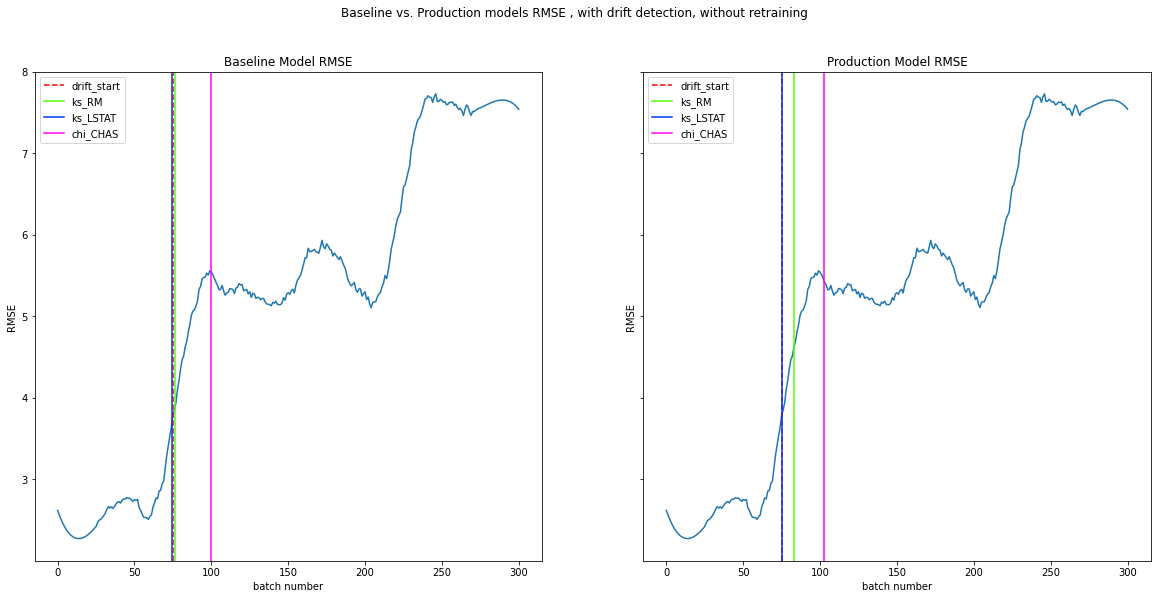

In [20]:
fig, axs = plt.subplots(1,2,figsize=(20, 9),sharey=True)
display_run(perf_kpis_base,base_drift_detector,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod,drift_detector,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

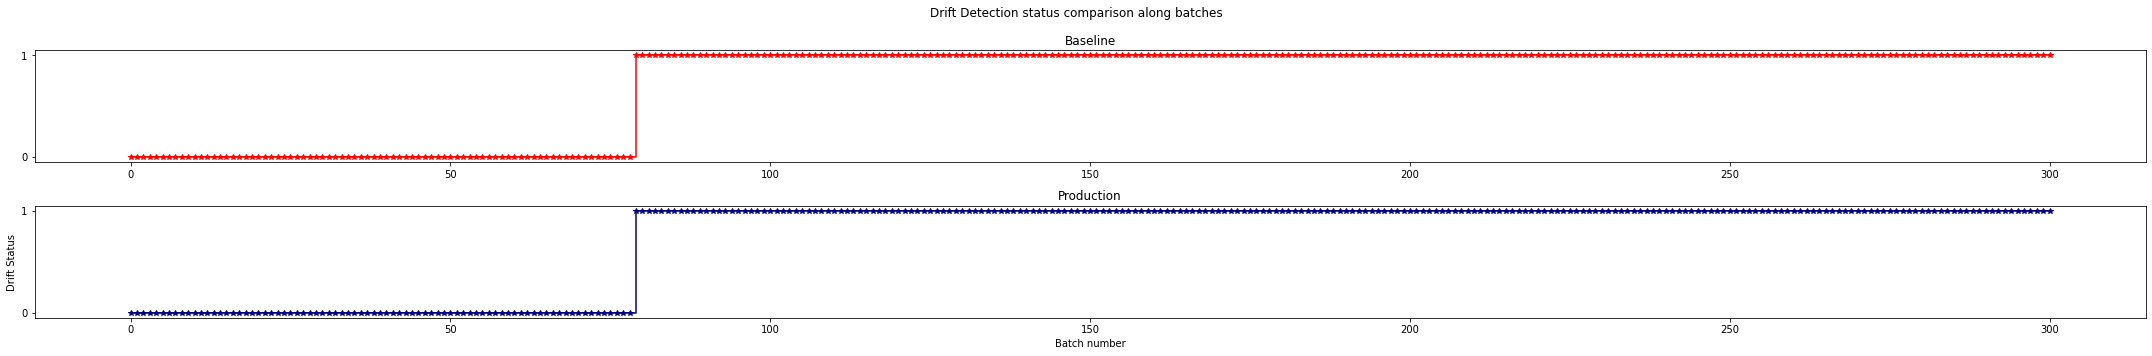

In [21]:
show_drift_detection_step(perf_kpis_base,perf_kpis_prod,title='Drift Detection status comparison along batches')

In [22]:
print('BASELINE')
perf_kpis_base

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.815335,0.748651,1.614726,1.614726,2.737432,0.0,[],NaN
2,0.934996,0.911522,1.495738,1.495738,2.053425,0.0,[],NaN
3,0.909394,0.876675,1.804021,1.804021,2.443613,0.0,[],NaN
4,0.948951,0.930516,1.397447,1.397447,2.037600,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,0.263383,-0.002618,5.379374,5.379374,6.509494,1.0,"[ks_RM, ks_LSTAT]",NaN
297,0.275196,0.013461,6.404850,6.404850,7.975705,1.0,"[ks_RM, ks_LSTAT]",NaN
298,0.185101,-0.109168,6.497845,6.497845,8.088536,1.0,"[ks_RM, ks_LSTAT]",NaN
299,0.434935,0.230884,6.350297,6.350297,8.084744,1.0,"[ks_RM, ks_LSTAT]",NaN


In [23]:
print('PRODUCTION')
perf_kpis_prod

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.815335,0.748651,1.614726,1.614726,2.737432,False,[],False
2,0.934996,0.911522,1.495738,1.495738,2.053425,False,[],False
3,0.909394,0.876675,1.804021,1.804021,2.443613,False,[],False
4,0.948951,0.930516,1.397447,1.397447,2.037600,False,[],False
...,...,...,...,...,...,...,...,...
296,0.263383,-0.002618,5.379374,5.379374,6.509494,True,"[ks_RM, ks_LSTAT]",False
297,0.275196,0.013461,6.404850,6.404850,7.975705,True,"[ks_RM, ks_LSTAT]",False
298,0.185101,-0.109168,6.497845,6.497845,8.088536,True,"[ks_RM, ks_LSTAT]",False
299,0.434935,0.230884,6.350297,6.350297,8.084744,True,"[ks_RM, ks_LSTAT]",False


## Summary Results

Should be the same for both

In [24]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[-1]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[-1]['RMSE']))


Initial Baseline RMSE on test set: 2.7572
Initial Production RMSE on test set: 2.7572
**************************************************
Final Baseline RMSE on test set: 6.5194
Final Production RMSE on test set: 6.5194


# Runtime 2 - Inference Drift Detection (with retraining)

In [25]:
%%time

# Init fresh start
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,baseline_model2,production_model2 = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,X_noisy,y_noisy = \
      run_drift_demo(X,y,number_of_batches=300,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model2,drift_detector=drift_detector2,perf_kpis_prod=perf_kpis_prod2,
                   baseline_model=baseline_model2,baseline_drift_detector=base_drift_detector2,
                   perf_kpis_base=perf_kpis_base2,retrain_on_drift=True,sample_size=100,
                   noise_factor=ds_noise_factor)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 1min 46s, sys: 3.53 s, total: 1min 49s
Wall time: 1min 49s


## Plot RMSE for Baseline vs. Production

Drift Detected and automatically handled by retraining

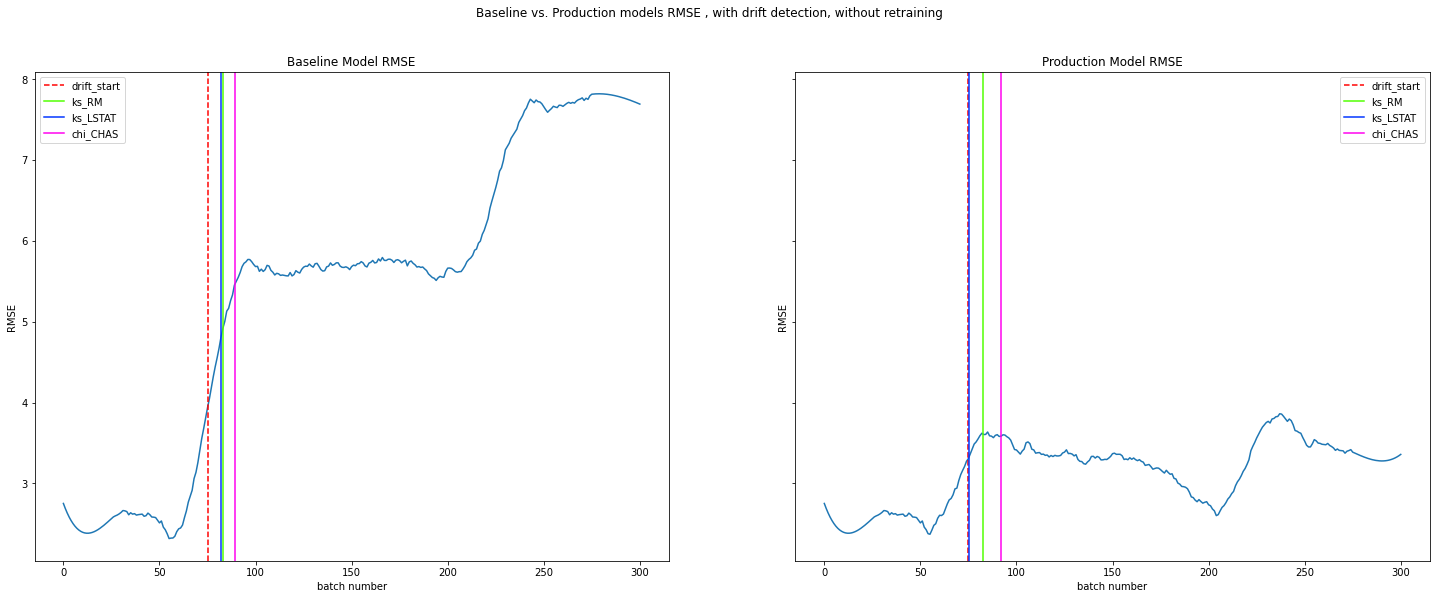

In [26]:
fig, axs = plt.subplots(1,2,figsize=(25, 9),sharey=True)
display_run(perf_kpis_base2,base_drift_detector2,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

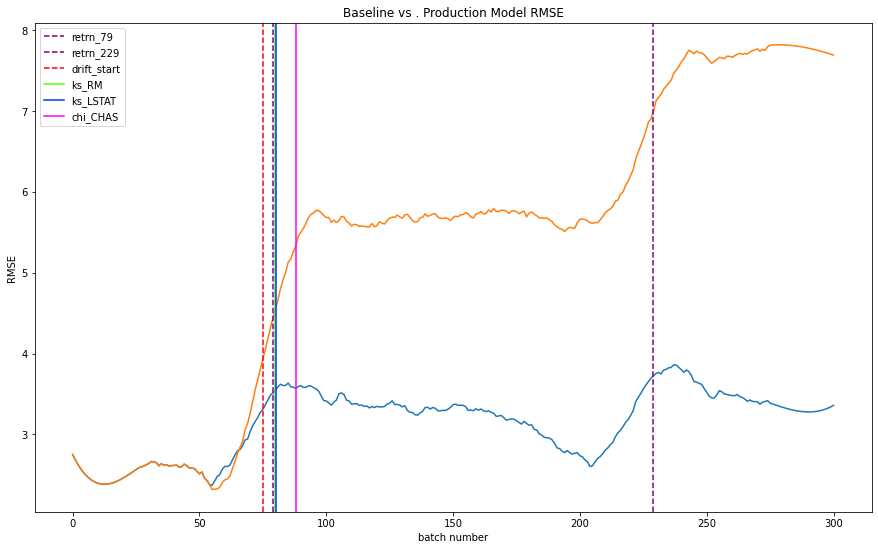

In [27]:
fig, axs = plt.subplots(1,1,figsize=(15, 9))
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs,title='Baseline vs . Production Model RMSE',
            baseline_perf_kpis=perf_kpis_base2,show_train=True)
plt.show()

In [28]:
print('BASELINE'),display(perf_kpis_base2)

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.930640,0.920155,1.813926,1.813926,2.702565,0.0,[],NaN
2,0.937201,0.927708,1.573157,1.573157,2.254323,0.0,[],NaN
3,0.881887,0.864032,1.768800,1.768800,3.035264,0.0,[],NaN
4,0.929954,0.919365,1.746496,1.746496,2.556039,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,0.237462,0.122195,7.152668,7.152668,8.825079,1.0,"[ks_RM, ks_LSTAT]",NaN
297,0.295051,0.188489,6.000136,6.000136,7.774004,1.0,"[ks_RM, ks_LSTAT]",NaN
298,0.309276,0.204865,6.523231,6.523231,7.700391,1.0,"[ks_INDUS, ks_NOX, ks_RM, ks_LSTAT]",NaN
299,0.295306,0.188782,5.812807,5.812807,7.162626,1.0,"[ks_RM, ks_LSTAT]",NaN


(None, None)

In [29]:
print('PRODUCTION'),display(perf_kpis_prod2)

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.902974,0.896851,1.887497,1.887497,2.757203,0.0,[],0.0
1,0.930640,0.920155,1.813926,1.813926,2.702565,False,[],False
2,0.937201,0.927708,1.573157,1.573157,2.254323,False,[],False
3,0.881887,0.864032,1.768800,1.768800,3.035264,False,[],False
4,0.929954,0.919365,1.746496,1.746496,2.556039,False,[],False
...,...,...,...,...,...,...,...,...
296,0.842949,0.819209,2.570518,2.570518,4.005055,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False
297,0.905370,0.891065,2.161333,2.161333,2.848265,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False
298,0.918563,0.906253,2.092540,2.092540,2.644055,True,"[ks_INDUS, ks_NOX, ks_RM, ks_LSTAT, chi_CHAS]",False
299,0.899095,0.883842,1.880539,1.880539,2.710372,True,"[ks_RM, ks_LSTAT, chi_CHAS]",False


(None, None)

## Summary Results

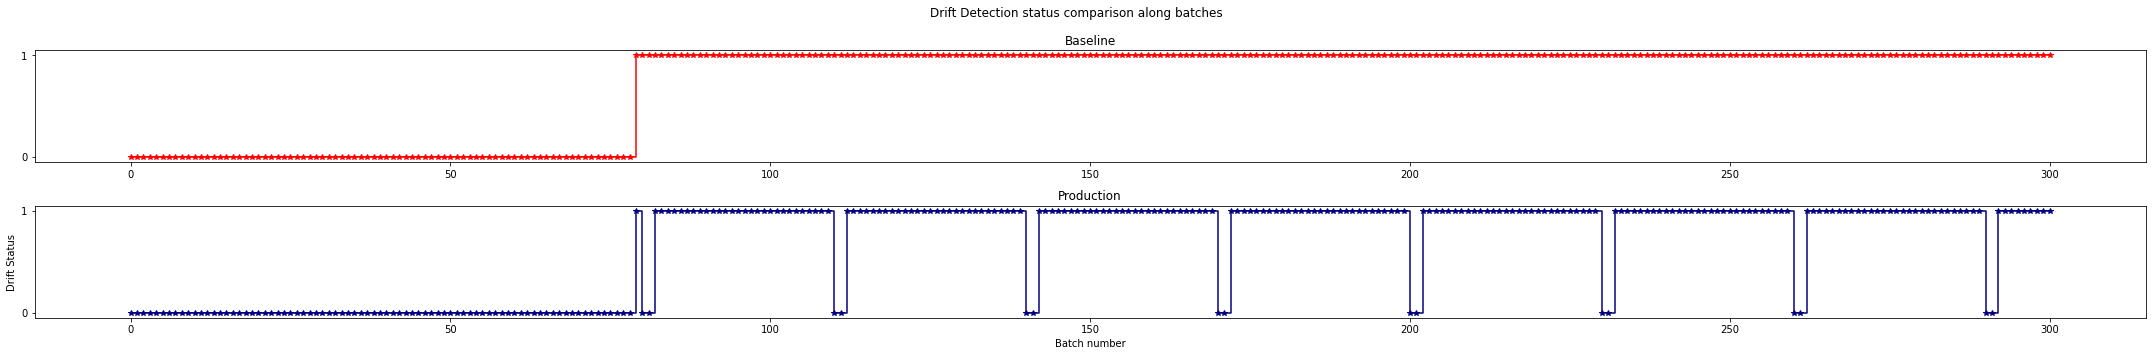

In [30]:
show_drift_detection_step(perf_kpis_base2,perf_kpis_prod2,title='Drift Detection status comparison along batches')

In [31]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[-100]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[-100]['RMSE']))

Initial Baseline RMSE on test set: 2.7572
Initial Production RMSE on test set: 2.7572
**************************************************
Final Baseline RMSE on test set: 6.1781
Final Production RMSE on test set: 2.9161


In [32]:
report_summary_kpi(perf_kpis_base2,perf_kpis_prod2)

Average RMSE on last 100 batches: Baseline:6.1781 vs. Production:2.9161
Production model is better by 3.2620 , a potential saving of 3262.02$ for the house predictions company


# NannyML DLE - RMSE Estimate

Additional independent estimate of the production model RMSE

In [33]:
base_df = X.copy()
prod_df = X_noisy.copy()
#baseline model on noisy data
base_df['y_true'] = y.copy()
base_df['y_pred'] = production_model2.predict(X)
#retrained model on noisy data
prod_df['y_pred'] = production_model2.predict(X_noisy)
base_df.shape,prod_df.shape

((2530, 15), (3330, 14))

In [34]:
import nannyml as nml
from IPython.display import display

# the DF for training the nanny model
reference_df = base_df
# a DF for the RMSE estimation of the nanny model
analysis_df = prod_df
estimator = nml.DLE(
    feature_column_names=x_cont_features+x_int_features+x_cat_features,
    y_pred='y_pred',
    y_true='y_true',
    # timestamp_column_name='timestamp',
    metrics=['rmse'],
    chunk_size=600,
    tune_hyperparameters=False
)

estimator.fit(reference_df)

results = estimator.estimate(analysis_df)
display(results.filter(period='analysis').to_df())

display(results.filter(period='reference').to_df())

metric_fig = results.plot()
metric_fig.show()




chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:599]           0           0       599       None     None   
1   [600:1199]           1         600      1199       None     None   
2  [1200:1799]           2        1200      1799       None     None   
3  [1800:2399]           3        1800      2399       None     None   
4  [2400:3329]           4        2400      3329       None     None   

                      rmse                                               \
     period sampling_error realized     value upper_confidence_boundary   
0  analysis       0.197449      NaN  2.525327                  3.117675   
1  analysis       0.197449      NaN  2.588606                  3.180953   
2  analysis       0.197449      NaN  2.642035                  3.234382   
3  analysis       0.197449      NaN  2.674897                  3.267244   
4  analysis       0.158595      NaN  8.732891                  9.208677   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.932979        2.838337        2.378625  False  
1                  1.996258        2.838337        2.378625  False  
2                  2.049687        2.838337        2.378625  False  
3                  2.082549        2.838337        2.378625  False  
4                  8.257106        2.838337        2.378625   True

chunk                                                        \
           key chunk_index start_index end_index start_date end_date   
0      [0:599]           0           0       599       None     None   
1   [600:1199]           1         600      1199       None     None   
2  [1200:1799]           2        1200      1799       None     None   
3  [1800:2529]           3        1800      2529       None     None   

                       rmse                                                \
      period sampling_error  realized     value upper_confidence_boundary   
0  reference       0.197449  2.513518  2.525327                  3.117675   
1  reference       0.197449  2.559054  2.588606                  3.180953   
2  reference       0.197449  2.652427  2.642035                  3.234382   
3  reference       0.179007  2.708927  2.685063                  3.222084   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.932979        2.838337        2.378625  False  
1                  1.996258        2.838337        2.378625  False  
2                  2.049687        2.838337        2.378625  False  
3                  2.148043        2.838337        2.378625  False

In [35]:
# the DF for training the nanny model
# reference1_df = nml.load_synthetic_car_price_dataset()[0]
# a DF for the RMSE estimation of the nanny model
# analysis1_df = nml.load_synthetic_car_price_dataset()[1]
display(reference_df)
display(analysis_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y_true,y_pred
0,0.070457,18.0,2.31,0,0.538650,6.575,64.759142,4.093071,1,296,15.3,396.90,4.98,24.0,29.022913
1,0.058989,0.0,7.07,0,0.469597,6.421,79.430377,4.963156,2,242,17.8,396.90,9.14,21.6,22.014404
2,-0.091092,0.0,7.07,0,0.468406,7.185,61.133471,4.985532,2,242,17.8,392.83,4.03,34.7,34.214085
3,-0.082456,0.0,2.18,0,0.458138,6.998,45.571149,6.060382,3,222,18.7,394.63,2.94,33.4,35.176044
4,0.037007,0.0,2.18,0,0.458367,7.147,54.259141,6.073643,3,222,18.7,396.90,5.33,36.2,33.142323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,0.107645,0.0,11.93,0,0.571252,6.593,68.805954,2.488342,1,273,21.0,391.99,9.67,22.4,19.360477
2526,-0.007299,0.0,11.93,0,0.571513,6.120,76.814152,2.255603,1,273,21.0,396.90,9.08,20.6,16.660070
2527,-0.017977,0.0,11.93,0,0.573980,6.976,90.730222,2.166948,1,273,21.0,396.90,5.64,23.9,24.300249
2528,0.074506,0.0,11.93,0,0.572531,6.794,89.592635,2.386821,1,273,21.0,393.45,6.48,22.0,25.001757


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y_pred
0,0.070457,18.0,2.31,0,0.538650,6.575000,64.759142,4.093071,1,296,15.3,396.90,4.980000,29.022913
1,0.058989,0.0,7.07,0,0.469597,6.421000,79.430377,4.963156,2,242,17.8,396.90,9.140000,22.014404
2,-0.091092,0.0,7.07,0,0.468406,7.185000,61.133471,4.985532,2,242,17.8,392.83,4.030000,34.214085
3,-0.082456,0.0,2.18,0,0.458138,6.998000,45.571149,6.060382,3,222,18.7,394.63,2.940000,35.176044
4,0.037007,0.0,2.18,0,0.458367,7.147000,54.259141,6.073643,3,222,18.7,396.90,5.330000,33.142323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,9.676608,0.0,18.10,1,0.692492,8.510184,100.213022,1.629322,24,666,20.2,376.11,41.716236,23.020153
1682,2.372166,0.0,19.58,1,0.606606,7.960184,92.177707,2.389437,5,403,14.7,395.11,33.046236,27.722517
2484,4.914437,0.0,18.10,1,0.713478,8.807184,89.955995,2.575914,24,666,20.2,255.23,37.826236,24.823336
1472,4.718962,0.0,18.10,1,0.710696,8.807184,89.995208,2.588167,24,666,20.2,255.23,37.826236,24.823336
